In [1]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [3]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

In [5]:
import gdown

In [6]:
data_folder='/content/drive/MyDrive/s1'

In [7]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [8]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [9]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

In [10]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [11]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    #file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('drive','MyDrive','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('drive','MyDrive','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [12]:
test_path='/content/drive/MyDrive/s1/bbal6n.mpg'

In [13]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))
#/content/drive/MyDrive/s1/bbal6n.align

In [14]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [15]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

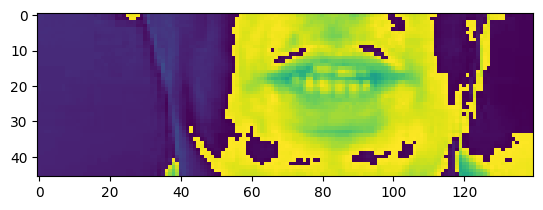

In [16]:
plt.imshow(frames[40])

In [17]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [18]:
data = tf.data.Dataset.list_files('/content/drive/MyDrive/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

In [19]:
train = data.take(450)
test = data.skip(450)

In [20]:
frames, alignments = data.as_numpy_iterator().next()

In [21]:
len(frames)

2

In [22]:
alignments

array([[16, 12,  1,  3,  5, 39,  2, 12, 21,  5, 39,  2, 25, 39, 22, 39,
         5,  9,  7,  8, 20, 39, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [12,  1, 25, 39,  7, 18,  5,  5, 14, 39,  1, 20, 39, 26, 39, 19,
         9, 24, 39, 14, 15, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [23]:
test=data.as_numpy_iterator()

In [24]:
val=test.next();

In [25]:
print(val[0][0].shape)

(75, 46, 140, 1)


In [26]:
temp=val[0][0]

In [27]:
imageio.mimsave("output.gif",(temp*255).astype(np.float32).squeeze(),duration=15)

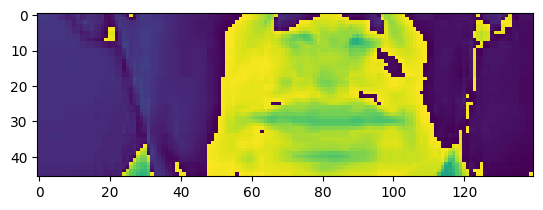

In [28]:
plt.imshow(val[0][0][0])

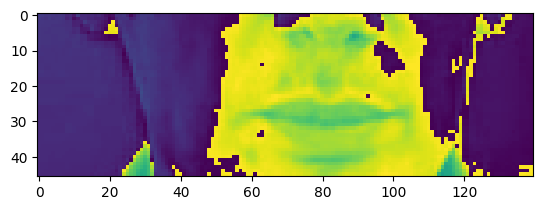

In [29]:
plt.imshow(val[0][0][35])

In [30]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay white with m zero now'>

In [31]:
val[1][0]

array([12,  1, 25, 39, 23,  8,  9, 20,  5, 39, 23,  9, 20,  8, 39, 13, 39,
       26,  5, 18, 15, 39, 14, 15, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0])

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D,LSTM,Dense, Dropout,Bidirectional,MaxPool3D,Activation,Reshape,SpatialDropout3D,BatchNormalization,TimeDistributed,Flatten
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler

In [33]:
model=Sequential()
model.add(Conv3D(128,3,input_shape=(75,46,140,1),padding="same"))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256,3,padding='same'))
model.add(Activation("relu"))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75,3,padding='same'))
model.add(Activation("relu"))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128,kernel_initializer="Orthogonal",return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128,kernel_initializer="Orthogonal",return_sequences=True)))
model.add(Dropout(0.5))

model.add(Dense(char_to_num.vocabulary_size()+1,kernel_initializer='he_normal', activation='softmax'))

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [35]:
y_pred=model.predict(val[0])

1/1 [==============================] - 35s 35s/step


In [36]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in y_pred[1]])

<tf.Tensor: shape=(), dtype=string, numpy=b'ii6666666666666666666666666666666666666666666666666666666666666666666666666'>

In [37]:
y_pred[0].shape

(75, 41)

In [38]:
tf.argmax(y_pred[0],axis=1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([27, 27, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
       35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
       35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
       35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
       35, 35, 35, 35, 35, 35, 35])>

In [39]:
model.input_shape

(None, 75, 46, 140, 1)

In [40]:
model.output_shape

(None, 75, 41)

In [41]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [42]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [43]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [44]:
model.compile(optimizer=SGD(learning_rate=0.0001), loss=CTCLoss,metrics=['accuracy'])

In [45]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [46]:
schedule_callback = LearningRateScheduler(scheduler)

In [47]:
example_callback = ProduceExample(test)

In [48]:
#model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

In [49]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From: https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:00<00:00, 118MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [50]:
model.load_weights('/content/models/checkpoint')

In [51]:
test_data=test.next()

In [52]:
y_hat=model.predict(test_data[0])

1/1 [==============================] - 17s 17s/step


In [53]:
decoded = tf.keras.backend.ctc_decode(y_hat, input_length=[75,75], greedy=True)[0][0].numpy()

In [54]:
print("*"*69,"PREDICTIONS")
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

********************************************************************* PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place red in p two please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set red with i five again'>]

In [55]:
print("*"*69,"REAL")
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [test_data[1]] ]

********************************************************************* REAL


[<tf.Tensor: shape=(), dtype=string, numpy=b'place red in p two pleaseset red with i five again'>]

In [58]:
sample,text=load_data(tf.convert_to_tensor('/content/drive/MyDrive/s1/bbaf3s.mpg'))

In [59]:
testing_predict=model.predict(tf.expand_dims(sample,axis=0))

1/1 [==============================] - 7s 7s/step


In [60]:
testing_predict.shape

(1, 75, 41)

In [61]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [text]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f three soon'>]

In [62]:
testing_predict[0]

array([[4.22543508e-07, 6.52433528e-07, 9.98966694e-01, ...,
        5.08781950e-09, 5.91678236e-06, 4.83381299e-08],
       [1.08996960e-06, 1.42557228e-05, 3.87699460e-04, ...,
        1.54643257e-10, 4.61981699e-06, 6.00006331e-07],
       [1.06377604e-06, 4.32246481e-04, 2.55364080e-06, ...,
        1.41647926e-11, 8.03491548e-06, 7.26686153e-07],
       ...,
       [9.99947429e-01, 4.94897179e-10, 1.33013223e-09, ...,
        7.56548296e-12, 7.54176721e-09, 5.22553928e-05],
       [1.07618456e-04, 6.23362084e-10, 6.99873604e-10, ...,
        3.15566930e-12, 3.51111473e-09, 9.99891877e-01],
       [9.99864459e-01, 3.34648198e-09, 8.05655365e-09, ...,
        1.17118579e-10, 7.61263692e-08, 1.34371934e-04]], dtype=float32)

In [63]:
decoded = tf.keras.backend.ctc_decode(testing_predict, input_length=[75], greedy=True)[0][0].numpy()

In [64]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [decoded]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at j three soon'>]